In [257]:
from bs4 import BeautifulSoup
import requests
import json 
import numpy as np

total_pages = 1100
DATA_LISTING = []
attributes = ["id", "addressPath", "price", "soldPrice", "unitNumber", "streetNumber", "streetName", "city", "bedrooms", "bedroomsPartial", "bathrooms", "bathroomsPartial", "parking", "styleName"]

for page in range(1, total_pages+1):
    if page%100 == 0:
        print(page)
    url = "https://www.zoocasa.com/toronto-on-sold-listings?page=" + str(page)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    #print(soup.prettify())
    script = soup.find('script', {'id': '__NEXT_DATA__'})
    #print(script.prettify())
    data = json.loads(script.text)  
    listing = data["props"]["pageProps"]["props"]["listingsData"]
    for i in range(len(listing)):
        d = [listing[i][m] for m in attributes]
        if listing[i]["position"]:
            lat = listing[i]["position"]["coordinates"][0]
            long = listing[i]["position"]["coordinates"][1] 
        else:
            lat = np.nan
            long = np.nan
        if listing[i]["squareFootage"]:
            #print(listing[i]["squareFootage"])
            sqft = np.mean([listing[i]["squareFootage"]["min"], listing[i]["squareFootage"]["max"]])
        else:
            sqft = np.nan
        d.extend([lat, long, sqft])
        #print(d)
        DATA_LISTING.append(d)

    
house_df = pd.DataFrame(DATA_LISTING, columns=attributes+["lat", "long", "sqft"])
house_df.head(3)
house_df.to_excel("house_2022.xlsx")

100
200
300
400
500
600
700
800
900
1000
1100


In [261]:
house_df = pd.DataFrame(DATA_LISTING, columns=attributes+["lat", "long", "sqft"])
house_df.head(3)
house_df.to_excel("house_2022.xlsx")

In [326]:
house_df = pd.read_excel("house_2022.xlsx")
house_df.dropna(subset=["soldPrice"],inplace=True)
house_df.head(3)

,Unnamed: 0,id,addressPath,price,soldPrice,unitNumber,streetNumber,streetName,city,bedrooms,bedroomsPartial,bathrooms,bathroomsPartial,parking,styleName,lat,long,sqft
0,0,11420738,/toronto-on-real-estate/1201-725-don-mills-rd,399000,495000.0,1201.0,725,Don Mills Rd,Toronto,1,NaN,1,NaN,1,condo-highrise,-79.333309,43.711450,649.5
1,1,11408550,/toronto-on-real-estate/12-58-sherwood-ave,450000,551718.0,12.0,58,Sherwood Ave,Toronto,1,NaN,1,NaN,0,condo-highrise,-79.396794,43.714438,649.5
2,2,11421073,/toronto-on-real-estate/3901-117-mcmahon-dr,499900,585000.0,3901.0,117,Mcmahon Dr,Toronto,0,NaN,1,NaN,1,condo-highrise,-79.370733,43.767222,249.5


In [327]:
house_df.bedroomsPartial = house_df.bedroomsPartial.fillna(0)
house_df.bedrooms = house_df.bedrooms.fillna(0)
house_df.bathroomsPartial = house_df.bathroomsPartial.fillna(0)

# Merge with Demographic Data
It's clear that neighborhood with high income professional will be more expensive


In [328]:
import os
import shapefile
import pandas as pd
from shapely.geometry import Point, Polygon
shape = shapefile.Reader(os.path.join(os.getcwd(),'dataset',"Neighbourhoods.shp"))
data_geo = []
for i in range(len(shape.shapeRecords())):
    feature = shape.shapeRecords()[i].__geo_interface__
    neighborhood = feature['properties']['FIELD_8']
    neighborhood_id = feature['properties']['FIELD_5']
    geometry = feature['geometry']['coordinates']
    polygon = Polygon([Point(p) for p in geometry[0]])
    data_geo.append([neighborhood.split('(')[0], neighborhood_id, polygon])
geodf = pd.DataFrame(data_geo, columns=['neighborhood', 'neighborhood_id', 'polygon'])
geodf.neighborhood_id.astype('int64')

0       96
1       95
2      109
3       64
4      103
      ... 
135    126
136    133
137     22
138     37
139     51
Name: neighborhood_id, Length: 140, dtype: int64

In [329]:
census_data = pd.read_csv(os.path.join(os.getcwd(),'dataset',"neighbourhood-profiles-2016-csv.csv"))
census_data.head(3)

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"


In [330]:
income_data = census_data[(census_data.Characteristic == "Neighbourhood Number")|(census_data.Characteristic == "Total income: Average amount ($)")]
income_data=income_data.T.reset_index()
income_data.columns = ['property','neighborhood_id', 'Avg_Income']
income_data.head(10)

,property,neighborhood_id,Avg_Income
0,_id,1,2273
1,Category,Neighbourhood Information,Income
2,Topic,Neighbourhood Information,Income sources
3,Data Source,City of Toronto,Catalogue no. 98-400-X2016122
4,Characteristic,Neighbourhood Number,Total income: Average amount ($)
5,City of Toronto,NaN,"52,268"
6,Agincourt North,129,"30,414"
7,Agincourt South-Malvern West,128,"31,825"
8,Alderwood,20,"47,709"
9,Annex,95,"112,766"


In [331]:
income_data=income_data.iloc[6:, :] # the first 6 rows are irrelevant
income_data['Avg_Income'] = income_data['Avg_Income'].apply(lambda z: z.replace(',','')).astype('int64')
income_data['neighborhood_id'] = income_data['neighborhood_id'].astype('int64')
income_data.head(3)

,property,neighborhood_id,Avg_Income
6,Agincourt North,129,30414
7,Agincourt South-Malvern West,128,31825
8,Alderwood,20,47709


In [332]:
income_geodf = geodf.merge(income_data, left_on=["neighborhood_id"], right_on=["neighborhood_id"])
income_geodf.head(3)

,neighborhood,neighborhood_id,polygon,property,Avg_Income
0,Casa Loma,96,"POLYGON ((-79.41469317817781 43.6739104164259,...",Casa Loma,165047
1,Annex,95,"POLYGON ((-79.39414141343561 43.6687202679382,...",Annex,112766
2,Caledonia-Fairbank,109,"POLYGON ((-79.4602100514917 43.6815584573051, ...",Caledonia-Fairbank,35112


# Group the Listing Based on Neighborhood

In [333]:
def check_area(point,df, attr):
    area = []
    for sh in df.polygon:
        within = point.within(sh)
        area.append(within)        
    if True in area:  return [df.loc[area.index(True), a] for a in attr] 
    else: return [np.nan, np.nan, np.nan]         

In [334]:
attr = ["neighborhood", "neighborhood_id", "Avg_Income"]
house_demo = []
for i in range(len(house_df)):
    location = Point(house_df.loc[i, "lat"], house_df.loc[i, "long"])
    house_demo.append(check_area(location, income_geodf, attr))
house_demodf = pd.DataFrame(house_demo, columns=attr)

In [335]:
house_df = pd.concat([house_df, house_demodf], axis=1)
house_df.head(3)

,Unnamed: 0,id,addressPath,price,soldPrice,unitNumber,streetNumber,streetName,city,bedrooms,...,bathrooms,bathroomsPartial,parking,styleName,lat,long,sqft,neighborhood,neighborhood_id,Avg_Income
0,0,11420738,/toronto-on-real-estate/1201-725-don-mills-rd,399000,495000.0,1201.0,725,Don Mills Rd,Toronto,1,...,1,0.0,1,condo-highrise,-79.333309,43.711450,649.5,Flemingdon Park,44,28654
1,1,11408550,/toronto-on-real-estate/12-58-sherwood-ave,450000,551718.0,12.0,58,Sherwood Ave,Toronto,1,...,1,0.0,0,condo-highrise,-79.396794,43.714438,649.5,Mount Pleasant East,99,85340
2,2,11421073,/toronto-on-real-estate/3901-117-mcmahon-dr,499900,585000.0,3901.0,117,Mcmahon Dr,Toronto,0,...,1,0.0,1,condo-highrise,-79.370733,43.767222,249.5,Bayview Village,52,52035


# Exploring Data

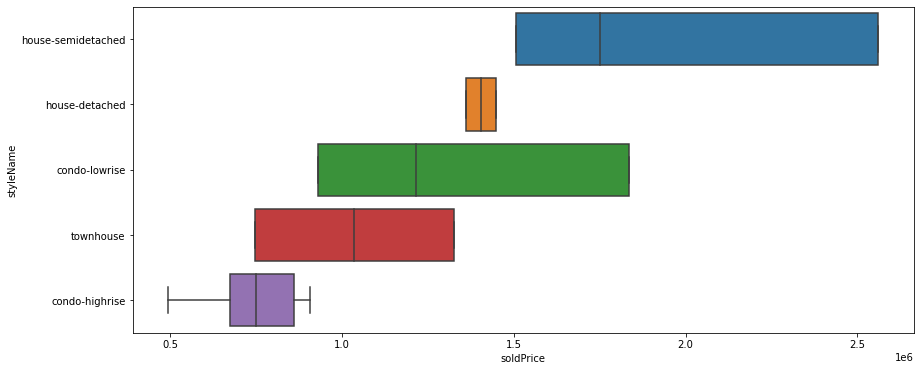

In [336]:
import matplotlib.pyplot as plt
import seaborn as sns

median = []
for key, df in house_df.groupby("styleName"):
    median.append((key,df["soldPrice"].median()))
median.sort(key=lambda z: z[1], reverse=True)
    

fig, ax = plt.subplots(figsize = [14,6])
sns.boxplot(y = "styleName", x="soldPrice", data = house_df, meanline=True, order = [a[0] for a in median])
plt.show()

